# Load Data and Compare Transcriptions

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import quail
import pickle
import scipy
import scipy.stats
from scipy.stats import pearsonr
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from itertools import groupby

%matplotlib inline

In [2]:
#get names of all files (subject names) we want lists from
filenames = []
for f in os.listdir('/Users/contextlab/Desktop/Google/'):
    if f != '.DS_Store':
        filenames.append(f)

OSError: [Errno 2] No such file or directory: '/Users/contextlab/Desktop/Google/'

In [ ]:
# load in egg with all words presented
egg = pickle.load(open('../data/automatic_transcription.p', 'rb'))

# get subject ids
filenames = egg.meta['ids']

# add the two sub ids missing from the meta data
filenames.append(u'debugZANF1E:debugNSAB89')
filenames.append(u'debugQVC5IH:debugWA2XJU')

In [ ]:
#these lists will contain an average value for each subject
ALL_LISTS_BACK_COUNTER_MAN = [] 
ALL_LISTS_BACK_COUNTER_AUTO = []

ALL_NUM_WORDS_RECALLED_MAN = []
ALL_NUM_WORDS_RECALLED_AUTO = []

ALL_AUTO_IN_MAN=[]
ALL_MAN_IN_AUTO=[]

ALL_ERROR_PREV_MAN=[]
ALL_ERROR_PREV_AUTO=[]

ALL_ERROR_EXTERNAL_MAN = []
ALL_ERROR_EXTERNAL_AUTO = []

ALL_LIST_AUTO_IN_MAN = []
ALL_LIST_AUTO_NOT_IN_MAN = []

ALL_WORDS_MAN = []
ALL_WORDS_AUTO = []

SUBS=[]

path = '/Users/contextlab/Desktop'

#compare man and auto transcriptions for each subject
for idx,subject in enumerate(filenames):
    
    
    #change into subject directory
    auto_folder= path + '/Google/' + subject
    man_folder = path + '/PennTotalRecall/' + subject
    
    #these lists will contain a value for each word list
    ALL_PRESENTED = []
    LISTS_BACK_COUNTER_MAN = [0, 0, 0, 0, 0, 0, 0, 0]
    LISTS_BACK_COUNTER_AUTO = [0, 0, 0, 0, 0, 0, 0, 0]
    
    NUM_WORDS_RECALLED_MAN_LIST = []
    NUM_WORDS_RECALLED_AUTO_LIST = []
    
    PROP_AUTO_IN_MAN_LIST=[]
    PROP_MAN_IN_AUTO_LIST=[]
    
    PROP_ERROR_PREV_MAN_LIST=[]
    PROP_ERROR_PREV_AUTO_LIST=[]
    
    PROP_ERROR_EXTERNAL_MAN_LIST=[]
    PROP_ERROR_EXTERNAL_AUTO_LIST=[]
    
    LIST_AUTO_NOT_IN_MAN = []
    LIST_AUTO_IN_MAN = []
    
    SUBS.append(subject)
    
    
    # FOR EACH LIST
    
    for x in range(0,8):

        list_num = x
        AUTO = [] #list of words in auto transcription
        MAN = [] #list of words in man transcription
        
        # LOAD AUTO FILES
        os.chdir(auto_folder)
        AUTO_file = open(subject + '-' + str(x)+ '.wav.txt')
        AUTO_contents = AUTO_file.read().split('\n')
        for line in AUTO_contents:
            word = line.split(',')
            if word[0] != '':
                AUTO.append(word[0])
            AUTO_file.close()
        os.chdir('../../')
        
        # LOAD MAN FILES
        os.chdir(man_folder)
        MAN_file = open('new' + subject + '-' + str(x) + '.ann')
        MAN_contents = MAN_file.read().split('\n')
        for line in MAN_contents:
            split_line = line.split('\t')
            if len(split_line) == 3:
                MAN.append(split_line[2])
            MAN_file.close()
        os.chdir('../../')
        
        # words presented
        presented = egg.pres.loc[idx].loc[list_num].values
        
        # get number of recalled words (man and auto)
        NUM_WORDS_RECALLED_MAN = float(len(MAN))
        NUM_WORDS_RECALLED_AUTO = float(len(AUTO))
        
        # add words to list of total words recalled
        ALL_WORDS_MAN.append(MAN)
        ALL_WORDS_AUTO.append(AUTO)
        
        # see if transcriptions match
        MATCH=0
        MATCH2=0
        
        #for every word in MAN that exists also in AUTO, count it in MATCH
        
#         MATCH = len(set(AUTO).intersection(MAN))
#         MATCH2 = len(set(AUTO).intersection(MAN))
        
        for x in AUTO:
            if x in MAN:
                MATCH += 1
            
        #for every word in AUTO that exists also in MAN, count it in MATCH2
        for x in MAN:
            if x in AUTO:
                MATCH2 += 1
                LIST_AUTO_IN_MAN.append(x)
            else:
                LIST_AUTO_NOT_IN_MAN.append(x)
        
        #check for errors
        #see if errors match any previously presented words
        MATCH_PREV_MAN = 0
        MATCH_PREV_AUTO = 0
        #see if errors match any words not previously presented (external errors)
        MATCH_EXTERNAL_MAN = 0
        MATCH_EXTERNAL_AUTO = 0
        
        #check for errors in manually transcribed list
        for x in MAN:
            #for every word in previous lists that is recalled in MAN, count in MATCH_PREV_MAN
            for listnum in ALL_PRESENTED:
                if x in listnum:
                    MATCH_PREV_MAN += 1
            #if the word was presented in the current list, it's not an error
            if x in presented:
                pass
            #for every word that is recalled in MAN but wasn't presented, count in MATCH_EXTERNAL_MAN
            else:
                MATCH_EXTERNAL_MAN += 1
                
            #if word was recalled from a previous list, add one to the index of LIST_BACK_COUNTER_MAN
            #for example, a one-back error would add one to LIST_BACK_COUNTER_MAN[1]
            for idxcounterman, words in enumerate(ALL_PRESENTED, start = 0):
                if x in words:
                    lists_back = (len(ALL_PRESENTED)+1) - (idxcounterman+1)
                    LISTS_BACK_COUNTER_MAN[lists_back] += 1.0 #num at index is num errors made that index lists back
    
        for x in AUTO:
            #for every word in previous lists that is recalled in AUTO, count in MATCH_PREV_AUTO
            for listnum in ALL_PRESENTED:
                if x in listnum:
                    MATCH_PREV_AUTO += 1
            #if the word was presented in the current list, it's not an error
            if x in presented:
                pass
            #for every word that is recalled in AUTO but wasn't presented, count in MATCH_EXTERNAL_AUTO
            else:
                MATCH_EXTERNAL_AUTO += 1
            
            #if word was recalled from a previous list, add one to the index of LIST_BACK_COUNTER_AUTO
            for idxcounterauto, words in enumerate(ALL_PRESENTED, start = 0):
                if x in words:
                    lists_back = (len(ALL_PRESENTED)+1) - (idxcounterauto+1)
                    LISTS_BACK_COUNTER_AUTO[lists_back] += 1.0 #num at index is num errors made that index lists back

        #get proportion of words in auto transcription that are also in man
        PROP_AUTO_IN_MAN = float(MATCH)/float(len(AUTO))
        #add that proportion to list of auto in man proportions for the subject
        PROP_AUTO_IN_MAN_LIST.append(PROP_AUTO_IN_MAN)

        #get proportion of words in man transcription that are also in auto
        PROP_MAN_IN_AUTO = float(MATCH2)/float(len(MAN))
        #add that proportion to list of man in auto proportions for the subject
        PROP_MAN_IN_AUTO_LIST.append(PROP_MAN_IN_AUTO)
            
        #get proportion of all words recalled from this list that are previous list errors, in manual transcription
        PROP_ERROR_PREV_MAN = float(MATCH_PREV_MAN)/float(len(MAN))
        #add that proportion to list of previous error proportions for the subject
        PROP_ERROR_PREV_MAN_LIST.append(PROP_ERROR_PREV_MAN)
            
        #get proportion of all words recalled from this list that are previous list errors, in auto transcription
        PROP_ERROR_PREV_AUTO = float(MATCH_PREV_AUTO)/float(len(AUTO))
        #add that proportion to list of previous error proportions for the subject
        PROP_ERROR_PREV_AUTO_LIST.append(PROP_ERROR_PREV_AUTO)
            
        #get proportion of all words recalled from this list that are external errors, in manual transcription
        PROP_ERROR_EXTERNAL_MAN = float(MATCH_EXTERNAL_MAN)/float(len(MAN))
        #add that proportion to list of external error proportions for the subject
        PROP_ERROR_EXTERNAL_MAN_LIST.append(PROP_ERROR_EXTERNAL_MAN)
            
        #get proportion of all words recalled from this list that are external errors, in auto transcription
        PROP_ERROR_EXTERNAL_AUTO = float(MATCH_EXTERNAL_AUTO)/float(len(AUTO))
        #add that proportion to list of external error proportions for the subject
        PROP_ERROR_EXTERNAL_AUTO_LIST.append(PROP_ERROR_EXTERNAL_AUTO)
        
        #add words presented in this list to list of all words that have been presented to the subject so far
        #this is a list of all word lists subject has seen
        ALL_PRESENTED.append(presented) 
        
        #add number of words recalled in this list to list for subject
        #this will have one value for each list that represents the total number of words that were transcribed
        NUM_WORDS_RECALLED_MAN_LIST.append(NUM_WORDS_RECALLED_MAN)
        NUM_WORDS_RECALLED_AUTO_LIST.append(NUM_WORDS_RECALLED_AUTO)
        
    #APPEND THIS INDIVIDUAL'S CONCATENATED LISTS TO LIST OF ALL SUBJECTS
    ALL_AUTO_IN_MAN.append(np.array(PROP_AUTO_IN_MAN_LIST))
    ALL_MAN_IN_AUTO.append(np.array(PROP_MAN_IN_AUTO_LIST))
    ALL_ERROR_PREV_MAN.append(np.array(PROP_ERROR_PREV_MAN_LIST))
    ALL_ERROR_PREV_AUTO.append(np.array(PROP_ERROR_PREV_AUTO_LIST))
    ALL_ERROR_EXTERNAL_MAN.append(np.array(PROP_ERROR_EXTERNAL_MAN_LIST))
    ALL_ERROR_EXTERNAL_AUTO.append(np.array(PROP_ERROR_EXTERNAL_AUTO_LIST))
    ALL_LISTS_BACK_COUNTER_MAN.append(LISTS_BACK_COUNTER_MAN)
    ALL_LISTS_BACK_COUNTER_AUTO.append(LISTS_BACK_COUNTER_AUTO)
    ALL_NUM_WORDS_RECALLED_MAN.append(NUM_WORDS_RECALLED_MAN_LIST)
    ALL_NUM_WORDS_RECALLED_AUTO.append(NUM_WORDS_RECALLED_AUTO_LIST)
    ALL_LIST_AUTO_IN_MAN.append(LIST_AUTO_IN_MAN)
    ALL_LIST_AUTO_NOT_IN_MAN.append(LIST_AUTO_NOT_IN_MAN)


# Prior list intrusions

#### Get number of previous list errors for each subject, man and auto

In [3]:
#these lists will have number of words recalled that were previous list errors, from manual transcription
ONE_BACK_ERRORS_MAN = []
TWO_BACK_ERRORS_MAN = []
THREE_BACK_ERRORS_MAN = []
FOUR_BACK_ERRORS_MAN = []
FIVE_BACK_ERRORS_MAN = []
SIX_BACK_ERRORS_MAN = []
SEVEN_BACK_ERRORS_MAN = []

#add number of previous list errors for each subject to the corresponding list
for subject in ALL_LISTS_BACK_COUNTER_MAN:
    ONE_BACK_ERRORS_MAN.append(subject[1])
    TWO_BACK_ERRORS_MAN.append(subject[2])
    THREE_BACK_ERRORS_MAN.append(subject[3])
    FOUR_BACK_ERRORS_MAN.append(subject[4])
    FIVE_BACK_ERRORS_MAN.append(subject[5])
    SIX_BACK_ERRORS_MAN.append(subject[6])
    SEVEN_BACK_ERRORS_MAN.append(subject[7])

#these lists will have number of words recalled that were previous list errors, from auto transcription
ONE_BACK_ERRORS_AUTO = []
TWO_BACK_ERRORS_AUTO = []
THREE_BACK_ERRORS_AUTO = []
FOUR_BACK_ERRORS_AUTO = []
FIVE_BACK_ERRORS_AUTO = []
SIX_BACK_ERRORS_AUTO = []
SEVEN_BACK_ERRORS_AUTO = []

#add number of previous list errors for each subject to the corresponding list
for subject in ALL_LISTS_BACK_COUNTER_AUTO:
    ONE_BACK_ERRORS_AUTO.append(subject[1])
    TWO_BACK_ERRORS_AUTO.append(subject[2])
    THREE_BACK_ERRORS_AUTO.append(subject[3])
    FOUR_BACK_ERRORS_AUTO.append(subject[4])
    FIVE_BACK_ERRORS_AUTO.append(subject[5])
    SIX_BACK_ERRORS_AUTO.append(subject[6])
    SEVEN_BACK_ERRORS_AUTO.append(subject[7])

NameError: name 'ALL_LISTS_BACK_COUNTER_MAN' is not defined

#### Get proportion of words recalled that were previous list errors

In [7]:
#here, each subject has a list of proportions, which are prop words recalled that are prev list errors
#index of each proportion corresponds to number lists back error was from 
PREV_LIST_ERROR_PROPS_MAN = []
PREV_LIST_ERROR_PROPS_AUTO = []

#MAN TRANSCRIPTIONS
#get proportions
for idx, subject in enumerate(ALL_LISTS_BACK_COUNTER_MAN, start = 0):
    list_back_errors = subject
    total_recalled_in_list = ALL_NUM_WORDS_RECALLED_MAN[idx]
    prop_list = np.divide(list_back_errors, total_recalled_in_list)
    PREV_LIST_ERROR_PROPS_MAN.append(prop_list)

#sort proportions into corresponding "-back error" lists
ONE_BACK_ERROR_PROPS_MAN = []
TWO_BACK_ERROR_PROPS_MAN = []
THREE_BACK_ERROR_PROPS_MAN = []
FOUR_BACK_ERROR_PROPS_MAN = []
FIVE_BACK_ERROR_PROPS_MAN = []
SIX_BACK_ERROR_PROPS_MAN = []
SEVEN_BACK_ERROR_PROPS_MAN = []

for sub in PREV_LIST_ERROR_PROPS_MAN:
    ONE_BACK_ERROR_PROPS_MAN.append(sub[1])
    TWO_BACK_ERROR_PROPS_MAN.append(sub[2])
    THREE_BACK_ERROR_PROPS_MAN.append(sub[3])
    FOUR_BACK_ERROR_PROPS_MAN.append(sub[4])
    FIVE_BACK_ERROR_PROPS_MAN.append(sub[5])
    SIX_BACK_ERROR_PROPS_MAN.append(sub[6])
    SEVEN_BACK_ERROR_PROPS_MAN.append(sub[7])

#AUTO TRANSCRIPTIONS
#get proportions
for idx, subject in enumerate(ALL_LISTS_BACK_COUNTER_AUTO, start = 0):
    list_back_errors = subject
    total_recalled_in_list = ALL_NUM_WORDS_RECALLED_AUTO[idx]
    prop_list = np.divide(list_back_errors, total_recalled_in_list)
    PREV_LIST_ERROR_PROPS_AUTO.append(prop_list)

#sort proportions into corresponding "-back error" lists
ONE_BACK_ERROR_PROPS_AUTO = []
TWO_BACK_ERROR_PROPS_AUTO = []
THREE_BACK_ERROR_PROPS_AUTO = []
FOUR_BACK_ERROR_PROPS_AUTO = []
FIVE_BACK_ERROR_PROPS_AUTO = []
SIX_BACK_ERROR_PROPS_AUTO = []
SEVEN_BACK_ERROR_PROPS_AUTO = []

for sub in PREV_LIST_ERROR_PROPS_AUTO:
    ONE_BACK_ERROR_PROPS_AUTO.append(sub[1])
    TWO_BACK_ERROR_PROPS_AUTO.append(sub[2])
    THREE_BACK_ERROR_PROPS_AUTO.append(sub[3])
    FOUR_BACK_ERROR_PROPS_AUTO.append(sub[4])
    FIVE_BACK_ERROR_PROPS_AUTO.append(sub[5])
    SIX_BACK_ERROR_PROPS_AUTO.append(sub[6])
    SEVEN_BACK_ERROR_PROPS_AUTO.append(sub[7])

#### Create data frame for each list back
Each data frame includes subject number, normalized prev list error proportion, and transcription type (man or auto)

In [8]:
#ONE LIST BACK ERRORS
ONE_BACK_DATA = []
i = 1
while i < 31:
    MAN_PROP = float(ONE_BACK_ERROR_PROPS_MAN[i-1])/16
    ONE_BACK_DATA.append({'Subject': i, 'Proportion of Total Possible Errors' : MAN_PROP, 'Transcription Type' : 'Manual'})
    AUTO_PROP = float(ONE_BACK_ERROR_PROPS_AUTO[i-1])/16
    ONE_BACK_DATA.append({'Subject': i, 'Proportion of Total Possible Errors' : AUTO_PROP, 'Transcription Type' : 'Automatic'})
    i+=1
ONE_BACK_DF = pd.DataFrame(ONE_BACK_DATA)

#TWO LIST BACK ERRORS
TWO_BACK_DATA = []
i =1
while i < 31:
    MAN_PROP = float(TWO_BACK_ERROR_PROPS_MAN[i-1])/32
    TWO_BACK_DATA.append({'Subject': i, 'Proportion of Total Possible Errors' : MAN_PROP, 'Transcription Type' : 'Manual'})
    AUTO_PROP = float(TWO_BACK_ERROR_PROPS_AUTO[i-1])/32
    TWO_BACK_DATA.append({'Subject': i, 'Proportion of Total Possible Errors' : AUTO_PROP, 'Transcription Type' : 'Automatic'})
    i+=1
TWO_BACK_DF = pd.DataFrame(TWO_BACK_DATA)

#THREE LIST BACK ERRORS
THREE_BACK_DATA = []
i = 1
while i < 31:
    MAN_PROP = float(THREE_BACK_ERROR_PROPS_MAN[i-1])/48
    THREE_BACK_DATA.append({'Subject': i, 'Proportion of Total Possible Errors' : MAN_PROP, 'Transcription Type' : 'Manual'})
    AUTO_PROP = float(THREE_BACK_ERROR_PROPS_AUTO[i-1])/48
    THREE_BACK_DATA.append({'Subject': i, 'Proportion of Total Possible Errors' : AUTO_PROP, 'Transcription Type' : 'Automatic'})
    i+=1
THREE_BACK_DF = pd.DataFrame(THREE_BACK_DATA)

#FOUR LIST BACK ERRORS
FOUR_BACK_DATA = []
i = 1
while i < 31:
    MAN_PROP = float(FOUR_BACK_ERROR_PROPS_MAN[i-1])/64
    FOUR_BACK_DATA.append({'Subject': i, 'Proportion of Total Possible Errors' : MAN_PROP, 'Transcription Type' : 'Manual'})
    AUTO_PROP = float(FOUR_BACK_ERROR_PROPS_AUTO[i-1])/64
    FOUR_BACK_DATA.append({'Subject': i, 'Proportion of Total Possible Errors' : AUTO_PROP, 'Transcription Type' : 'Automatic'})
    i+=1
FOUR_BACK_DF = pd.DataFrame(FOUR_BACK_DATA)

#FIVE LIST BACK ERRORS
FIVE_BACK_DATA = []
i = 1
while i < 31:
    MAN_PROP = float(FIVE_BACK_ERROR_PROPS_MAN[i-1])/80
    FIVE_BACK_DATA.append({'Subject': i, 'Proportion of Total Possible Errors' : MAN_PROP, 'Transcription Type' : 'Manual'})
    AUTO_PROP = float(FIVE_BACK_ERROR_PROPS_AUTO[i-1])/80
    FIVE_BACK_DATA.append({'Subject': i, 'Proportion of Total Possible Errors' : AUTO_PROP, 'Transcription Type' : 'Automatic'})
    i+=1
FIVE_BACK_DF = pd.DataFrame(FIVE_BACK_DATA)

#SIX LIST BACK ERRORS
SIX_BACK_DATA = []
i = 1
while i < 31:
    MAN_PROP = float(SIX_BACK_ERROR_PROPS_MAN[i-1])/96
    SIX_BACK_DATA.append({'Subject': i, 'Proportion of Total Possible Errors' : MAN_PROP, 'Transcription Type' : 'Manual'})
    AUTO_PROP = float(SIX_BACK_ERROR_PROPS_AUTO[i-1])/96
    SIX_BACK_DATA.append({'Subject': i, 'Proportion of Total Possible Errors' : AUTO_PROP, 'Transcription Type' : 'Automatic'})
    i+=1
SIX_BACK_DF = pd.DataFrame(SIX_BACK_DATA)

In [9]:
#get average proportion of errors for each list back, manual transcription
MAN_AVG_PREV_ERRORS = []
MAN_AVG_PREV_ERRORS.append(sum(ONE_BACK_DF[ONE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'])/30)
MAN_AVG_PREV_ERRORS.append(sum(TWO_BACK_DF[TWO_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'])/30)
MAN_AVG_PREV_ERRORS.append(sum(THREE_BACK_DF[THREE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'])/30)
MAN_AVG_PREV_ERRORS.append(sum(FOUR_BACK_DF[FOUR_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'])/30)
MAN_AVG_PREV_ERRORS.append(sum(FIVE_BACK_DF[FIVE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'])/30)
MAN_AVG_PREV_ERRORS.append(sum(SIX_BACK_DF[SIX_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'])/30)

#get average proportion of errors for each list back, automatic transcription 
AUTO_AVG_PREV_ERRORS = []
AUTO_AVG_PREV_ERRORS.append(sum(ONE_BACK_DF[ONE_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'])/30)
AUTO_AVG_PREV_ERRORS.append(sum(TWO_BACK_DF[TWO_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'])/30)
AUTO_AVG_PREV_ERRORS.append(sum(THREE_BACK_DF[THREE_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'])/30)
AUTO_AVG_PREV_ERRORS.append(sum(FOUR_BACK_DF[FOUR_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'])/30)
AUTO_AVG_PREV_ERRORS.append(sum(FIVE_BACK_DF[FIVE_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'])/30)
AUTO_AVG_PREV_ERRORS.append(sum(SIX_BACK_DF[SIX_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'])/30)

#### Plot average proportion of list back errors for each list back

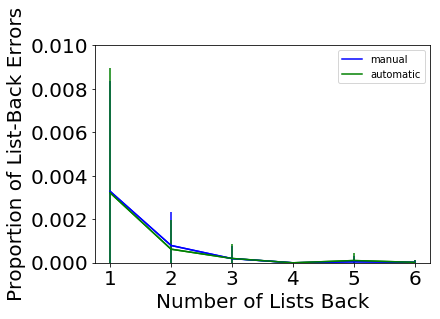

In [10]:
current_palette = sns.color_palette()

#plot points
fig, ax = plt.subplots()
plt.plot(range(1, 7), MAN_AVG_PREV_ERRORS, color = 'blue', label = 'manual')
plt.plot(range(1, 7), AUTO_AVG_PREV_ERRORS, color = 'green', label = 'automatic')

#add error bars
yerr_man = []
yerr_man.append(np.std(ONE_BACK_DF[ONE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors']))
yerr_man.append(np.std(TWO_BACK_DF[TWO_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors']))
yerr_man.append(np.std(THREE_BACK_DF[THREE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors']))
yerr_man.append(np.std(FOUR_BACK_DF[FOUR_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors']))                
yerr_man.append(np.std(FIVE_BACK_DF[FIVE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors']))
yerr_man.append(np.std(SIX_BACK_DF[SIX_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors']))                

yerr_auto = []
yerr_auto.append(np.std(ONE_BACK_DF[ONE_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors']))
yerr_auto.append(np.std(TWO_BACK_DF[TWO_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors']))
yerr_auto.append(np.std(THREE_BACK_DF[THREE_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors']))
yerr_auto.append(np.std(FOUR_BACK_DF[FOUR_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors']))                
yerr_auto.append(np.std(FIVE_BACK_DF[FIVE_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors']))
yerr_auto.append(np.std(SIX_BACK_DF[SIX_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors']))                                
                
plt.errorbar(range(1,7), MAN_AVG_PREV_ERRORS, yerr = yerr_man,  color = 'blue')
plt.errorbar(range(1,7), AUTO_AVG_PREV_ERRORS, yerr = yerr_auto,  color = 'green')

#label axes
plt.xlabel('Number of Lists Back', size = 20)
plt.ylabel('Proportion of List-Back Errors', size = 20)
plt.tick_params(labelsize=20)
plt.xticks([1,2,3,4,5,6])
plt.ylim([0, 0.01])

#make a legend
ax.legend()

#save plot and show
#plt.savefig('../AutoFR-figures/errorsbylistbackscatter.pdf')
plt.show()

#### Add to grid with list-back figures

In [11]:
#divide by 10^-3 for prop list back errors plot
MAN_AVG_PREV_ERRORS_divided = [x/10e-3 for x in MAN_AVG_PREV_ERRORS]
MAN_AVG_PREV_ERRORS_divided = MAN_AVG_PREV_ERRORS_divided[:-1]
AUTO_AVG_PREV_ERRORS_divided = [x/10e-3 for x in AUTO_AVG_PREV_ERRORS]
AUTO_AVG_PREV_ERRORS_divided = AUTO_AVG_PREV_ERRORS_divided[:-1]


one_back_divided_man = [x/10e-3 for x in list(ONE_BACK_DF[ONE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'])]
two_back_divided_man = [x/10e-3 for x in list(TWO_BACK_DF[TWO_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'])]
three_back_divided_man = [x/10e-3 for x in list(THREE_BACK_DF[THREE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'])]
four_back_divided_man = [x/10e-3 for x in list(FOUR_BACK_DF[FOUR_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'])]
five_back_divided_man = [x/10e-3 for x in list(FIVE_BACK_DF[FIVE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'])]

yerr_man = []
yerr_man.append(np.std(one_back_divided_man))
yerr_man.append(np.std(two_back_divided_man))
yerr_man.append(np.std(three_back_divided_man))
yerr_man.append(np.std(four_back_divided_man))
yerr_man.append(np.std(five_back_divided_man))

one_back_divided_auto = [x/10e-3 for x in list(ONE_BACK_DF[ONE_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'])]
two_back_divided_auto = [x/10e-3 for x in list(TWO_BACK_DF[TWO_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'])]
three_back_divided_auto = [x/10e-3 for x in list(THREE_BACK_DF[THREE_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'])]
four_back_divided_auto = [x/10e-3 for x in list(FOUR_BACK_DF[FOUR_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'])]
five_back_divided_auto = [x/10e-3 for x in list(FIVE_BACK_DF[FIVE_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'])]

yerr_auto = []
yerr_auto.append(np.std(one_back_divided_auto))
yerr_auto.append(np.std(two_back_divided_auto))
yerr_auto.append(np.std(three_back_divided_auto))
yerr_auto.append(np.std(four_back_divided_auto))
yerr_auto.append(np.std(five_back_divided_auto))

(0.94556324368722766, 3.5173899792318626e-15)
(0.8489489313912536, 3.0537524850093859e-09)
(0.99169090993724551, 1.7406855493006056e-26)
(0.99169090993724551, 1.7406855493006056e-26)
(0.73762884992468125, 3.3070606877086598e-06)


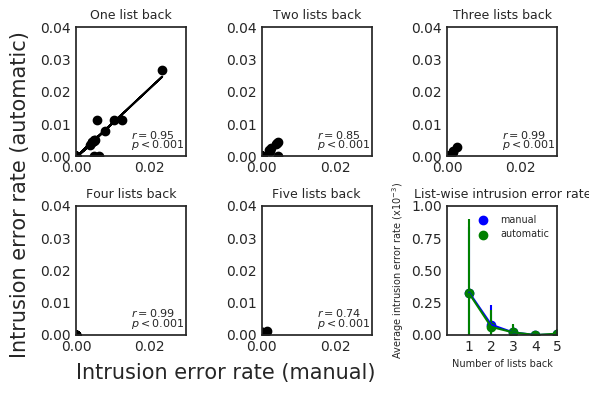

In [12]:
#set up grid of six scatter plots, one for each list-back error
#plots show man vs. auto transcription for prev list error proportions
#each point represents a subject
sns.set_style('white')

fig = plt.figure()





#PLOT ONE LIST BACK ERRORS
ax1 = fig.add_subplot(2, 3, 1)
ax1.scatter(ONE_BACK_DF[ONE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'], ONE_BACK_DF[ONE_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'], color = 'black', edgecolors = 'black')
ax1.set_title('One list back', size = 9)
#get line of best fit
reg_line = np.polyfit(ONE_BACK_DF[ONE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'], ONE_BACK_DF[ONE_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'], 1)
reg_line_fn = np.poly1d(reg_line)
ax1.plot(ONE_BACK_DF[ONE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'], reg_line_fn(ONE_BACK_DF[ONE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors']), color = 'black')
#get R value
r = pearsonr(ONE_BACK_DF[ONE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'], ONE_BACK_DF[ONE_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'])
ax1.text(0.015, 0.0055, '$r=0.95$', size = 8)
ax1.text(0.015, 0.0025, '$p<0.001$', size = 8)
#set x and y lim
ax1.set_xlim(0, 0.03)
ax1.set_ylim(0, 0.04)
print r

#PLOT TWO LIST BACK ERRORS
ax2 = fig.add_subplot(2, 3, 2, sharex = ax1, sharey = ax1)
ax2.scatter(TWO_BACK_DF[TWO_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'], TWO_BACK_DF[TWO_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'], color = 'black', edgecolors = 'black')
ax2.set_title('Two lists back', size = 9)
#get line of best fit
reg_line = np.polyfit(TWO_BACK_DF[TWO_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'], TWO_BACK_DF[TWO_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'], 1)
reg_line_fn = np.poly1d(reg_line)
ax2.plot(TWO_BACK_DF[TWO_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'], reg_line_fn(TWO_BACK_DF[TWO_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors']), color = 'black')
#get R value
r = pearsonr(TWO_BACK_DF[TWO_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'], TWO_BACK_DF[TWO_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'])
ax2.text(0.015, 0.0055, '$r=0.85$', size = 8)
ax2.text(0.015, 0.0025, '$p<0.001$', size = 8)
#set x and y lim
ax2.set_xlim(0, 0.03)
ax2.set_ylim(0, 0.04)
print r

#PLOT THREE LIST BACK ERRORS
ax3 = fig.add_subplot(2, 3, 3, sharex = ax1, sharey = ax1)
ax3.scatter(THREE_BACK_DF[THREE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'], THREE_BACK_DF[THREE_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'], color = 'black', edgecolors = 'black')
ax3.set_title('Three lists back', size = 9)
#get line of best fit
reg_line = np.polyfit(THREE_BACK_DF[THREE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'], THREE_BACK_DF[THREE_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'], 1)
reg_line_fn = np.poly1d(reg_line)
ax3.plot(THREE_BACK_DF[THREE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'], reg_line_fn(THREE_BACK_DF[THREE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors']), color = 'black')
#get R value
r = pearsonr(THREE_BACK_DF[THREE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'], THREE_BACK_DF[THREE_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'])
ax3.text(0.015, 0.0055, '$r=0.99$', size = 8)
ax3.text(0.015, 0.0025, '$p<0.001$', size = 8)
#set x and y lim
ax3.set_xlim(0, 0.03)
ax3.set_ylim(0, 0.04)
print r

#PLOT FOUR LIST BACK ERRORS
ax4 = fig.add_subplot(2, 3, 4, sharex = ax1, sharey = ax1)
ax4.scatter(FOUR_BACK_DF[FOUR_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'], FOUR_BACK_DF[FOUR_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'], color = 'black', edgecolors = 'black')
ax4.set_title('Four lists back', size = 9)

ax4.text(0.015, 0.0055, '$r=0.99$', size = 8)
ax4.text(0.015, 0.0025, '$p<0.001$', size = 8)
#set x and y lim
ax4.set_xlim(0, 0.03)
ax4.set_ylim(0, 0.04)
print r

#PLOT FIVE LIST BACK ERRORS
ax5 = fig.add_subplot(2, 3, 5, sharex = ax1, sharey = ax1)
ax5.scatter(FIVE_BACK_DF[FIVE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'], FIVE_BACK_DF[FIVE_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'], color = 'black', edgecolors = 'black')
ax5.set_title('Five lists back', size = 9)
#get line of best fit
reg_line = np.polyfit(FIVE_BACK_DF[FIVE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'], FIVE_BACK_DF[FIVE_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'], 1)
reg_line_fn = np.poly1d(reg_line)
ax5.plot(FIVE_BACK_DF[FIVE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'], reg_line_fn(FIVE_BACK_DF[FIVE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors']), color = 'black')
#get R value
r = pearsonr(FIVE_BACK_DF[FIVE_BACK_DF['Transcription Type']=='Manual']['Proportion of Total Possible Errors'], FIVE_BACK_DF[FIVE_BACK_DF['Transcription Type']=='Automatic']['Proportion of Total Possible Errors'])
ax5.text(0.015, 0.0055, '$r=0.74$', size = 8)
ax5.text(0.015, 0.0025, '$p<0.001$', size = 8)
#set x and y lim
ax5.set_xlim(0, 0.03)
ax5.set_ylim(0, 0.04)
print r

#PLOT P(ERROR) BY LIST BACK
ax6 = fig.add_subplot(2, 3, 6)
ax6.scatter(range(1, 6), MAN_AVG_PREV_ERRORS_divided, color = 'blue', label = 'manual')
ax6.scatter(range(1, 6), AUTO_AVG_PREV_ERRORS_divided, color = 'green', label = 'automatic')
ax6.errorbar(range(1,6), MAN_AVG_PREV_ERRORS_divided, yerr = yerr_man,  color = 'blue')
ax6.errorbar(range(1,6), AUTO_AVG_PREV_ERRORS_divided, yerr = yerr_auto,  color = 'green')
ax6.set_title('List-wise intrusion error rate', size = 9)
#set axes labels
ax6.set_xlabel('Number of lists back', size = 7)
ax6.set_ylabel('Average intrusion error rate (x$10^{-3}$)', size = 7)
#set x and y lim
ax6.set_xlim(0, 5)
ax6.set_ylim(0, 1)
ax6.set_xticks([1,2,3,4,5])
#legend
ax6.legend(loc = 'upper right', fontsize = 'x-small')

#DISPLAY ALL PLOTS
#plt.xlim(0, 0.04)
#plt.ylim(0, 0.001)
fig.text(0.4, 0.04, 'Intrusion error rate (manual)', ha='center', size = 15)
fig.text(0.04, 0.5, 'Intrusion error rate (automatic)', va='center', rotation='vertical', size = 15)
plt.tight_layout()
plt.subplots_adjust(left = 0.15, bottom = 0.15)
plt.style.use('default')

plt.show()

# Extra List Intrusions

In [13]:
#this list will have one average proportion for each subject's manual transcription
ALL_ERROR_EXTERNAL_MAN_AVGS = []

#get average proportions for manual transcription
for sub in ALL_ERROR_EXTERNAL_MAN:
    AVG = float(sum(sub))/float(len(sub))
    ALL_ERROR_EXTERNAL_MAN_AVGS.append(AVG)

#this list will have one average proportion for each subject's automatic transcription
ALL_ERROR_EXTERNAL_AUTO_AVGS = []

#get average proportions for automatic transcription
for sub in ALL_ERROR_EXTERNAL_AUTO:
    AVG = float(sum(sub))/float(len(sub))
    ALL_ERROR_EXTERNAL_AUTO_AVGS.append(AVG)

(0.61048795101385567, 0.00034018848785556492)


IOError: [Errno 2] No such file or directory: '../AutoFR-figures/extralistintrusionerrors.pdf'

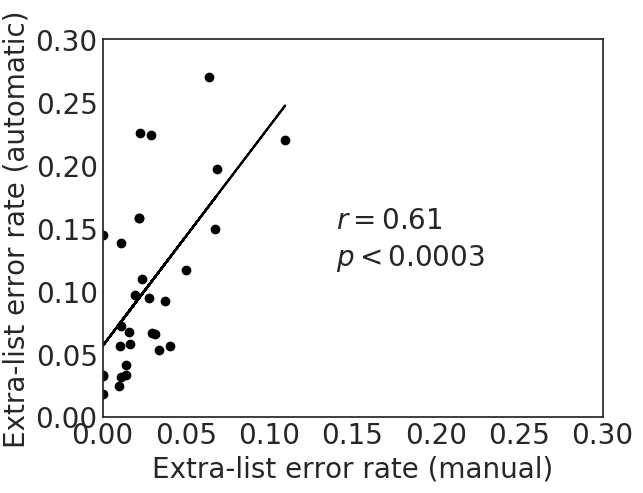

In [14]:
#plot average proportion of external errors in man vs. auto transcription on scatter plot
sns.set_style('white')
fig, ax = plt.subplots()
plt.scatter(ALL_ERROR_EXTERNAL_MAN_AVGS, ALL_ERROR_EXTERNAL_AUTO_AVGS, color = 'black', edgecolors = 'black')

#label axes
ax.set_xlabel('Extra-list error rate (manual)', size = 20)
ax.set_ylabel('Extra-list error rate (automatic)', size = 20)
plt.tick_params(labelsize=20)
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)

#get line of best fit
reg_line = np.polyfit(ALL_ERROR_EXTERNAL_MAN_AVGS, ALL_ERROR_EXTERNAL_AUTO_AVGS, 1)
reg_line_fn = np.poly1d(reg_line)
plt.plot(ALL_ERROR_EXTERNAL_MAN_AVGS, reg_line_fn(ALL_ERROR_EXTERNAL_MAN_AVGS), color = 'black')

#get R value
r = pearsonr(ALL_ERROR_EXTERNAL_MAN_AVGS, ALL_ERROR_EXTERNAL_AUTO_AVGS)
plt.text(0.14, 0.15, '$r = 0.61$', size = 20)
plt.text(0.14, 0.12, '$p < 0.0003$', size = 20)
print r

#save plot and show
plt.tight_layout()
plt.style.use('default')
plt.savefig('../AutoFR-figures/extralistintrusionerrors.pdf', bbox_inches = 'tight')
plt.show()

# Graveyard

Manual

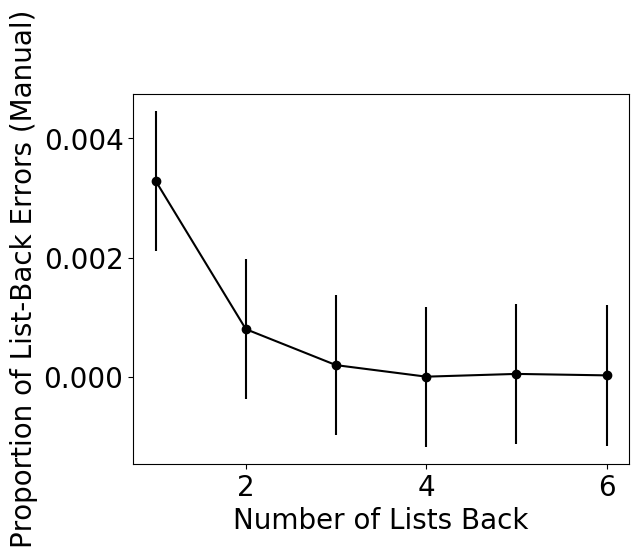

In [15]:
MAN_AVG_PREV_ERRORS = np.array(MAN_AVG_PREV_ERRORS)

#plot points
plt.plot(range(1, 7), MAN_AVG_PREV_ERRORS,'ko')

#add error bars
plt.errorbar(range(1,7), MAN_AVG_PREV_ERRORS, yerr=np.std(MAN_AVG_PREV_ERRORS),  color = 'k')

#label axes
plt.xlabel('Number of Lists Back', size = 20)
plt.ylabel('Proportion of List-Back Errors (Manual)', size = 20)
plt.tick_params(labelsize=20)

#save plot and show
#plt.savefig('../../AutoFR-figures/errorsbylistbackscatter.pdf')
plt.show()

Automatic

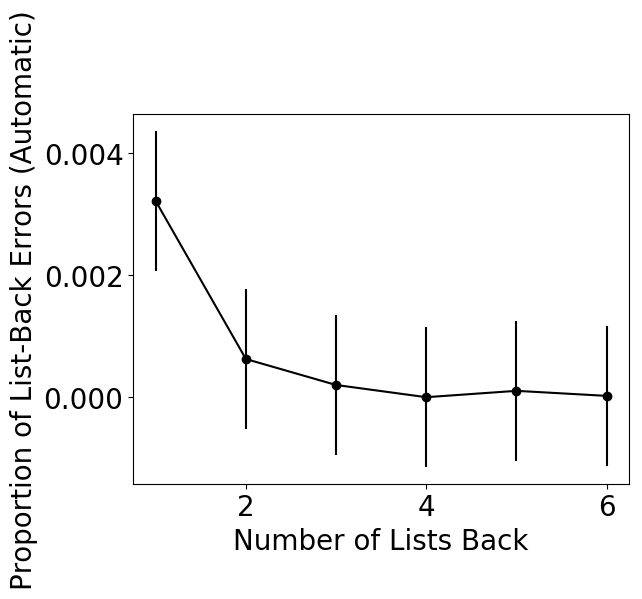

In [16]:
AUTO_AVG_PREV_ERRORS = np.array(AUTO_AVG_PREV_ERRORS)

#plot points
plt.plot(range(1, 7), AUTO_AVG_PREV_ERRORS,'ko')

#add error bars
plt.errorbar(range(1,7), AUTO_AVG_PREV_ERRORS, yerr=np.std(AUTO_AVG_PREV_ERRORS),  color = 'k')

#label axes
plt.xlabel('Number of Lists Back', size = 20)
plt.ylabel('Proportion of List-Back Errors (Automatic)', size = 20)
plt.tick_params(labelsize=20)

#save plot and show
#plt.savefig('../../AutoFR-figures/errorsbylistbackscatter.pdf')
plt.show()

IndexError: too many indices for array

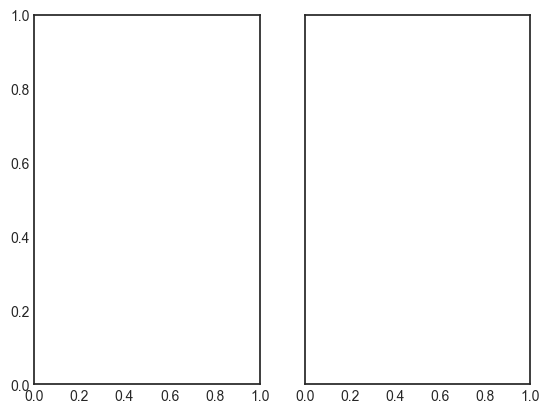

In [17]:
#trying to set up in grid form
sns.set_style('white')
fig,ax = plt.subplots(1,2, sharex=True, sharey=True)
ax[1,1].scatter([1,2,3], [1,2,3])
ax[1,2].scatter([1,2,3], [1,2,3])
plt.show()

IndexError: too many indices for array

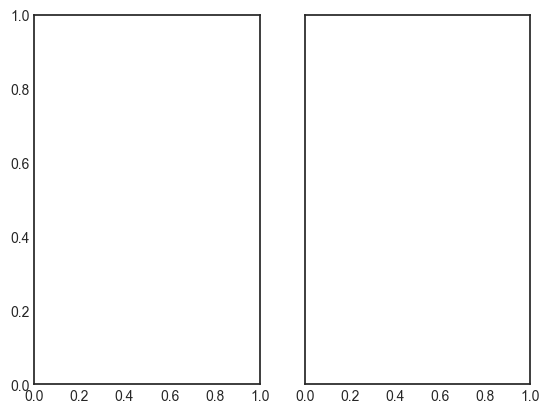

In [18]:
#plot average proportion of list back errors for each list back, both man and auto
MAN_AVG_PREV_ERRORS = np.array(MAN_AVG_PREV_ERRORS)
AUTO_AVG_PREV_ERRORS = np.array(AUTO_AVG_PREV_ERRORS)

#set up grid
sns.set_style('white')
fig,axtemp = plt.subplots(1,2, sharex=True, sharey=True)

#get curve of best fit for man
z_man = np.polyfit(range(1, 7), MAN_AVG_PREV_ERRORS, 3)
f_man = np.poly1d(z_man)
x_new_man = np.linspace(1, 6, 50)
y_new_man = f_man(x_new_man)
axtemp[1,1].scatter(range(1,7),MAN_AVG_PREV_ERRORS)
axtemp[1,1].plot(x_new_man, y_new_man)
#plt.plot(range(1, 7), MAN_AVG_PREV_ERRORS,'o', x_new_man, y_new_man, color = 'k')

plt.xlabel('Number of Lists Back', size = 20)
plt.ylabel('Proportion of List-Back Errors', size = 20)
plt.tick_params(labelsize=20)


#save plot and show
#plt.savefig('../../AutoFR-figures/errorsbylistbackscatter.pdf')
#plt.show()

#get curve of best fit for auto
z_auto = np.polyfit(range(1, 7), AUTO_AVG_PREV_ERRORS, 3)
f_auto = np.poly1d(z_auto)
x_new_auto = np.linspace(1, 6, 50)
y_new_auto = f_auto(x_new_auto)
axtemp[1,2].scatter(range(1, 7), MAN_AVG_PREV_ERRORS)
axtemp[1,2].plot(x_new_man, y_new_man)
#plt.plot(range(1, 7), AUTO_AVG_PREV_ERRORS,'o', x_new_auto, y_new_auto, color = 'k')

plt.xlabel('Number of Lists Back', size = 20)
plt.ylabel('Proportion of List-Back Errors', size = 20)
plt.tick_params(labelsize=20)


#save plot and show
#plt.savefig('../../AutoFR-figures/errorsbylistbackscatter.pdf')
plt.show()

#add error bars and axes labels
#plt.errorbar(range(1,7), MAN_AVG_PREV_ERRORS, yerr=np.std(MAN_AVG_PREV_ERRORS),  color = 'blue', fmt = 'o')
#plt.errorbar(range(1,7), AUTO_AVG_PREV_ERRORS, yerr=np.std(AUTO_AVG_PREV_ERRORS),  color = 'red', fmt = 'o')

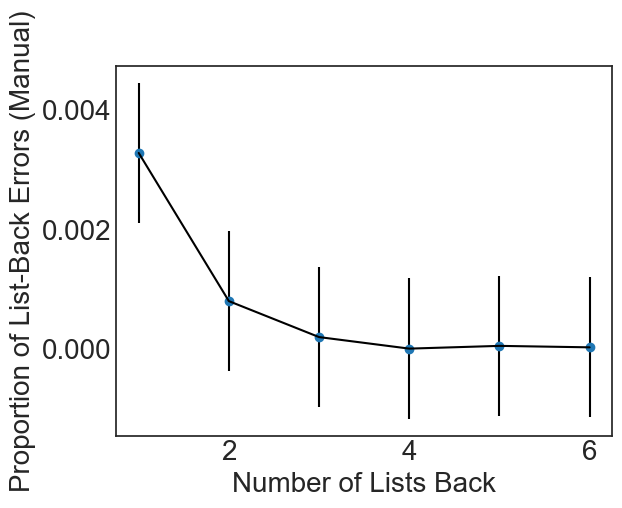

In [19]:
MAN_AVG_PREV_ERRORS = np.array(MAN_AVG_PREV_ERRORS)

#get curve of best fit
#z_man = np.polyfit(range(1, 7), MAN_AVG_PREV_ERRORS, 1)
#f_man = np.poly1d(z_man)
#x_new_man = np.linspace(1, 6, 50)
#y_new_man = f_man(x_new_man)
plt.plot(range(1, 7), MAN_AVG_PREV_ERRORS,'o')#, x_new_man, y_new_man, color = 'k')

#add error bars
plt.errorbar(range(1,7), MAN_AVG_PREV_ERRORS, yerr=np.std(MAN_AVG_PREV_ERRORS),  color = 'k')

#label axes
plt.xlabel('Number of Lists Back', size = 20)
plt.ylabel('Proportion of List-Back Errors (Manual)', size = 20)
plt.tick_params(labelsize=20)

#save plot and show
#plt.savefig('../../AutoFR-figures/errorsbylistbackscatter.pdf')
plt.show()